# Piano Transcription

The goal of this homework is implementing ``onsets and frames'', a state-of-the-art piano transcription model.

## Download the Dataset

We use a subset of the MAESTRO dataset that contains 170 performance pieces played by junior pianists. The audio files and their corresponding midi files are paired for each piece. We will convert the midi files into piano rolls and train our network to predict them from the audio in a supervised way. We randomly selected 100 / 20 / 50 (train / valid / test) performances from the original dataset for this homework.

In [1]:
# # Download the audio files
# !gdown 1EQ6fFJRhAEugkkCwG2YvmXJyL7Q3Xhes

In [2]:
# uncompress the audio files
# %%capture prevents the output log from displaying in this cell. If you want to see the log, remove %%capture below.
# %%capture

# !unzip gct634-maestro.zip

Once you unzip the file, you will see the following folders in the ``gct634-maestro'' folder.

```
2004  2006  2008  2009  2011  2013  2014  2015  2017  2018  data.json
```


## Check the Audio and MIDI Files

Install python packages to handle audio and MIDI

In [3]:
# %%capture prevents the output log from displaying in this cell. If you want to see the log, remove %%capture below.
# %%capture

# !sudo apt install -y fluidsynth
# !pip install --upgrade pyfluidsynth
# !pip install pretty_midi
# !pip install mir_eval
# !pip install libfmp


Let's load an example of the audio files.

In [4]:
import soundfile
import IPython.display as ipd

audio_file = 'gct634-maestro/2009/MIDI-Unprocessed_08_R1_2009_01-04_ORIG_MID--AUDIO_08_R1_2009_08_R1_2009_03_WAV.flac'
audio, sr = soundfile.read(audio_file)
audio_seg = audio[:10*sr]

ipd.Audio(audio_seg, rate=sr)


Can you hear the beautiful piano music? Then, let's load the paired MIDI file

(<Figure size 576x216 with 1 Axes>,
 <Axes: xlabel='Time (seconds)', ylabel='Pitch'>)

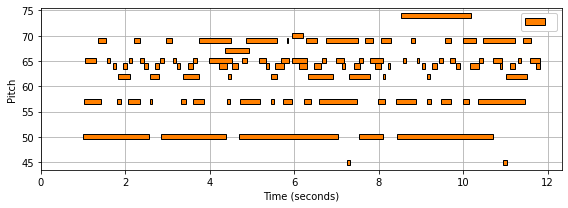

In [5]:
import libfmp.c1

midi_file = 'gct634-maestro/2009/MIDI-Unprocessed_08_R1_2009_01-04_ORIG_MID--AUDIO_08_R1_2009_08_R1_2009_03_WAV.midi'
score = libfmp.c1.midi_to_list(midi_file)
libfmp.c1.visualize_piano_roll(score[:100], figsize=(8, 3))

Now, we synthesize MIDI file back to audio using Fluidsynth

In [6]:
import fluidsynth
import pretty_midi

pm = pretty_midi.PrettyMIDI(midi_file)
synth_audio = pm.fluidsynth(fs=sr)

synth_audio_seg = synth_audio[:10*sr]

ipd.Audio(synth_audio_seg, rate=sr)

The piano timbre will be different. But, it should sound pretty good.

Now, we are going to build the onsets and frames model.

## Dataloader
This cell includes data loaders and mel-spectrogram setting. We are just going to use the functions.

In [7]:

# setup the basic data configuration
SAMPLE_RATE = 16000
MIN_MIDI = 21
MAX_MIDI = 108

HOP_SIZE = 512
N_MELS = 229
N_FFT = 2048
F_MIN = 30
F_MAX = 8000


from typing import Dict, List
from torch import Tensor
from numpy import ndarray
from numpy.random.mtrand import RandomState
from pretty_midi.pretty_midi import PrettyMIDI

import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

def allocate_batch(batch:Dict[str,Tensor], device:torch.device) -> Dict[str,Tensor]:
    for key in batch.keys():
        if key != 'path':
            batch[key] = batch[key].to(device)
    return batch

class MAESTRO_small(Dataset):
    def __init__(self,
                 path:str = 'gct634-maestro',
                 groups:List[str] = None,
                 sequence_length:int = SAMPLE_RATE * 5,
                 hop_size:int = HOP_SIZE,
                 seed:int = 42,
                 random_sample:bool = True) -> None:
        self.path:str = path
        self.groups:list = groups if groups is not None else self.available_groups()
        assert all(group in self.available_groups() for group in self.groups)

        self.sample_length:int = ((sequence_length // hop_size) * hop_size) if sequence_length is not None else None
        self.random:RandomState = np.random.RandomState(seed)
        self.random_sample:bool = random_sample
        self.hop_size:int = hop_size

        self.data:List[Dict[str,Tensor]] = []

        print(f'Loading {len(groups)} group(s) of', self.__class__.__name__, 'at', path)
        for group in groups:
            file_list:List[tuple] = self.get_file_path_list_of_group(group)
            for input_files in tqdm(file_list, desc=f'Loading group {group}'):
                self.data.append(self.load(*input_files))

    @classmethod
    def available_groups(cls) -> List[str]:
        return ['train', 'validation', 'test', 'debug']

    def get_file_path_list_of_group(self, group:str) -> List[tuple]:
        metadata:List[dict] = json.load(open(os.path.join(self.path, 'data.json')))
        subset_name:str = 'train' if group == 'debug' else group

        files:List[tuple] = sorted([
                (os.path.join(self.path, row['audio_filename'].replace('.wav', '.flac')),
                 os.path.join(self.path, row['midi_filename']))
                for row in metadata if row['split'] == subset_name
            ])

        if group == 'debug':
            files = files[:10]
        else:
            files = [(audio if os.path.exists(audio) else audio.replace(
                '.flac', '.wav'), midi) for audio, midi in files]

        return files

    def load(self, audio_path:str, midi_path:str) -> Dict[str,Tensor]:
        """Loads an audio track and the corresponding labels."""
        audio, sr = soundfile.read(audio_path, dtype='int16')
        assert sr == SAMPLE_RATE

        frames_per_sec:float = sr / self.hop_size

        audio_tensor:Tensor = torch.ShortTensor(audio)
        audio_length:int = len(audio_tensor)

        midi:PrettyMIDI = pretty_midi.PrettyMIDI(midi_path)
        midi_length_sec:float = midi.get_end_time()
        frame_length:int = min(int(midi_length_sec * frames_per_sec), (audio_length // self.hop_size) + 1)

        audio_tensor = audio_tensor[:frame_length * self.hop_size]

        frame:ndarray = midi.get_piano_roll(fs=frames_per_sec)

        onset = np.zeros_like(frame)
        for inst in midi.instruments:
            for note in inst.notes:
                onset[note.pitch, int(note.start * frames_per_sec)] = 1

        # to shape (time, pitch (88))
        frame_tensor:Tensor = torch.from_numpy(frame[MIN_MIDI:MAX_MIDI + 1].T)
        onset_tensor:Tensor = torch.from_numpy(onset[MIN_MIDI:MAX_MIDI + 1].T)
        data = dict(path=audio_path, audio=audio_tensor, frame=frame_tensor, onset=onset_tensor)
        return data

    def __getitem__(self, index:int) -> Dict[str,Tensor]:
        data:Dict[str,Tensor] = self.data[index]

        audio:Tensor = data['audio']
        frames:Tensor = (data['frame'] >= 1)
        onsets:Tensor = (data['onset'] >= 1)

        frame_len:int = frames.shape[0]

        if self.sample_length is not None:
            n_steps:int = self.sample_length // self.hop_size

            step_begin:int = self.random.randint(frame_len - n_steps) if self.random_sample else 0
            step_end:int = step_begin + n_steps

            sample_begin:int = step_begin * self.hop_size
            sample_end:int = sample_begin + self.sample_length

            audio_seg:Tensor = audio[sample_begin:sample_end]
            frame_seg:Tensor = frames[step_begin:step_end]
            onset_seg:Tensor = onsets[step_begin:step_end]

            result = dict(path=data['path'])
            result['audio'] = audio_seg.float().div_(32768.0)
            result['frame'] = frame_seg.float()
            result['onset'] = onset_seg.float()
        else:
            result = dict(path=data['path'])
            result['audio'] = audio.float().div_(32768.0)
            result['frame'] = frames.float()
            result['onset'] = onsets.float()

        return result

    def __len__(self) -> int:
        return len(self.data)




## Build the Model

This cell includes neural network modules to build the onsets and frames model along with the mel-spectrogram. This is the main part that you are going to work on for this homework.

In [ ]:
import random
import torch.nn as nn
import torchaudio.transforms as transforms

class LogMelSpectrogram(nn.Module):
    def __init__(self):
        super().__init__()
        self.melspectrogram = transforms.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_fft=N_FFT,
            hop_length=HOP_SIZE,
            f_min=F_MIN,
            f_max=F_MAX,
            n_mels=N_MELS,
            normalized=False)

    def forward(self, audio):
        # Alignment correction to match with piano roll.
        # When they convert the input into frames,
        # pretty_midi.get_piano_roll uses `ceil`,
        # but torchaudio.transforms.melspectrogram uses `round`.
        padded_audio = nn.functional.pad(audio, (HOP_SIZE // 2, 0), 'constant')
        mel = self.melspectrogram(padded_audio)[:, :, 1:]
        mel = mel.transpose(-1, -2)
        mel = torch.log(torch.clamp(mel, min=1e-9))
        return mel


class ConvStack(nn.Module):
    def __init__(self, n_mels, cnn_unit, fc_unit):
        super().__init__()

        # shape of input: (batch_size, 1 channel, frames, input_features)
        self.cnn = nn.Sequential(
            # layer 0
            nn.Conv2d(1, cnn_unit, (3, 3), padding=1),
            nn.BatchNorm2d(cnn_unit),
            nn.ReLU(),
            # layer 1
            nn.Conv2d(cnn_unit, cnn_unit, (3, 3), padding=1),
            nn.BatchNorm2d(cnn_unit),
            nn.ReLU(),
            # layer 2
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.25),
            nn.Conv2d(cnn_unit, cnn_unit * 2, (3, 3), padding=1),
            nn.BatchNorm2d(cnn_unit * 2),
            nn.ReLU(),
            # layer 3
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.25),
        )
        self.fc = nn.Sequential(
            nn.Linear((cnn_unit * 2) * (n_mels // 4), fc_unit),
            nn.Dropout(0.5))

    def forward(self, mel):
        x = mel.unsqueeze(1)
        x = self.cnn(x)
        x = x.transpose(1, 2).flatten(-2)
        x = self.fc(x)
        return x


class BiLSTM(nn.Module):
    inference_chunk_length = 512

    def __init__(self, input_features, recurrent_features):
        super().__init__()
        self.rnn = nn.LSTM(input_features, recurrent_features, batch_first=True, bidirectional=True)

    def forward(self, x):
        if self.training:
            return self.rnn(x)[0]
        else:
            # evaluation mode: support for longer sequences that do not fit in memory
            batch_size, sequence_length, input_features = x.shape
            hidden_size = self.rnn.hidden_size
            num_directions = 2 if self.rnn.bidirectional else 1

            h = torch.zeros(num_directions, batch_size, hidden_size, device=x.device)
            c = torch.zeros(num_directions, batch_size, hidden_size, device=x.device)
            output = torch.zeros(batch_size, sequence_length, num_directions * hidden_size, device=x.device)

            # forward direction
            slices = range(0, sequence_length, self.inference_chunk_length)
            for start in slices:
                end = start + self.inference_chunk_length
                output[:, start:end, :], (h, c) = self.rnn(x[:, start:end, :], (h, c))

            # reverse direction
            if self.rnn.bidirectional:
                h.zero_()
                c.zero_()

                for start in reversed(slices):
                    end = start + self.inference_chunk_length
                    result, (h, c) = self.rnn(x[:, start:end, :], (h, c))
                    output[:, start:end, hidden_size:] = result[:, :, hidden_size:]

            return output

class BasicOnsetsAndFrames(nn.Module):
    def __init__(self, cnn_unit, fc_unit):
        super().__init__()

        self.melspectrogram = LogMelSpectrogram()

        self.onset_stack = nn.Sequential(
            ConvStack(N_MELS, cnn_unit, fc_unit),
            nn.Linear(fc_unit, 88),
            nn.Sigmoid()
        )

        self.frame_stack = nn.Sequential(
            ConvStack(N_MELS, cnn_unit, fc_unit),
            nn.Linear(fc_unit, 88),
            nn.Sigmoid()
        )

    def forward(self, audio):
        mel = self.melspectrogram(audio)

        onset_pred = self.onset_stack(mel)  # (B, T, C)
        frame_pred = self.frame_stack(mel)  # (B, T, C)

        return frame_pred, onset_pred


class OnsetsAndFrames(nn.Module):
    def __init__(self, cnn_unit, fc_unit, rnn_unit):
        super().__init__()
        # Your part

        self.melspectrogram = LogMelSpectrogram()

        self.onset_stack = nn.Sequential(
            ConvStack(N_MELS, cnn_unit, fc_unit),
            BiLSTM(fc_unit, rnn_unit),
            nn.Linear(rnn_unit*2, 88),
            nn.Sigmoid()
        )

        self.pre_frame_stack = nn.Sequential(
            ConvStack(N_MELS, cnn_unit, fc_unit),
            nn.Linear(fc_unit, 88),
            nn.Sigmoid()
        )

        self.post_frame_stack = nn.Sequential(
            BiLSTM(88*2, rnn_unit),
            nn.Linear(rnn_unit*2, 88),
            nn.Sigmoid()
        )

    def forward(self, audio):
        # Your part

        mel = self.melspectrogram(audio)  # (B, T, F)
        onset_pred = self.onset_stack(mel)  # (B, T, C)
        frame_pred = self.pre_frame_stack(mel)
        frame_pred = torch.concat((frame_pred, onset_pred), dim=2)
        frame_pred = self.post_frame_stack(frame_pred)

        return frame_pred, onset_pred


## Evaluation Functions

This cell includes evaluation functions which compute frame-level and note-level accuracy metrics. ``extract_notes'' is used to infer MIDI notes from the onset and frame predictions.

In [9]:
import argparse
from datetime import datetime
from pathlib import Path
from collections import defaultdict

from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

from collections import defaultdict
from pathlib import Path

from mido import Message, MidiFile, MidiTrack
from mir_eval.transcription import precision_recall_f1_overlap as evaluate_notes
from mir_eval.util import hz_to_midi, midi_to_hz

def cycle(iterable):
    while True:
        for item in iterable:
            yield item

def evaluate(model, batch, device, save=False, save_path=None):
    metrics = defaultdict(list)
    batch = allocate_batch(batch, device)

    frame_pred, onset_pred = model(batch['audio'])

    criterion = nn.BCELoss()
    frame_loss = criterion(frame_pred, batch['frame'])
    onset_loss = criterion(onset_pred, batch['onset'])
    metrics['metric/loss/frame_loss'].append(frame_loss.cpu().numpy())
    metrics['metric/loss/onset_loss'].append(onset_loss.cpu().numpy())

    for batch_idx in range(batch['audio'].shape[0]):
        pr, re, f1 = framewise_eval(frame_pred[batch_idx], batch['frame'][batch_idx])
        metrics['metric/frame/frame_precision'].append(pr)
        metrics['metric/frame/frame_recall'].append(re)
        metrics['metric/frame/frame_f1'].append(f1)

        pr, re, f1 = framewise_eval(onset_pred[batch_idx], batch['onset'][batch_idx])
        metrics['metric/frame/onset_precision'].append(pr)
        metrics['metric/frame/onset_recall'].append(re)
        metrics['metric/frame/onset_f1'].append(f1)

        p_est, i_est = extract_notes(onset_pred[batch_idx], frame_pred[batch_idx])
        p_ref, i_ref = extract_notes(
            batch['onset'][batch_idx], batch['frame'][batch_idx])

        scaling = HOP_SIZE / SAMPLE_RATE

        i_ref = (i_ref * scaling).reshape(-1, 2)
        p_ref = np.array([midi_to_hz(MIN_MIDI + pitch) for pitch in p_ref])
        i_est = (i_est * scaling).reshape(-1, 2)
        p_est = np.array([midi_to_hz(MIN_MIDI + pitch) for pitch in p_est])

        p, r, f, o = evaluate_notes(
            i_ref, p_ref, i_est, p_est, offset_ratio=None)
        metrics['metric/note/precision'].append(p)
        metrics['metric/note/recall'].append(r)
        metrics['metric/note/f1'].append(f)
        metrics['metric/note/overlap'].append(o)

        p, r, f, o = evaluate_notes(i_ref, p_ref, i_est, p_est)
        metrics['metric/note-with-offsets/precision'].append(p)
        metrics['metric/note-with-offsets/recall'].append(r)
        metrics['metric/note-with-offsets/f1'].append(f)
        metrics['metric/note-with-offsets/overlap'].append(o)

    return metrics

def framewise_eval(pred, label, threshold=0.5):
    '''Evaluates frame-wise (point-wise) evaluation.

    Args:
        pred: torch.Tensor of shape (frame, pitch)
        label: torch.Tensor of shape (frame, pitch)
    '''

    tp = torch.sum((pred >= threshold) * (label == 1)).cpu().numpy()
    fn = torch.sum((pred < threshold) * (label == 1)).cpu().numpy()
    fp = torch.sum((pred >= threshold) * (label != 1)).cpu().numpy()

    pr = tp / float(tp + fp) if (tp + fp) > 0 else 0
    re = tp / float(tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * pr * re / float(pr + re) if (pr + re) > 0 else 0

    return pr, re, f1


def extract_notes(onsets, frames, onset_threshold=0.5, frame_threshold=0.5):
    """Finds the note timings based on the onsets and frames information.

    Args:
        onsets: torch.FloatTensor of shape (frames, bins)
        frames: torch.FloatTensor of shape (frames, bins)
        onset_threshold: float
        frame_threshold: float

    Returns:
        pitches: np.ndarray of bin_indices
        intervals: np.ndarray of rows containing (onset_index, offset_index)
    """
    onsets = (onsets > onset_threshold).type(torch.int).cpu()
    frames = (frames > frame_threshold).type(torch.int).cpu()
    onset_diff = torch.cat([onsets[:1, :], onsets[1:, :] - onsets[:-1, :]],
                           dim=0) == 1

    pitches = []
    intervals = []

    for nonzero in onset_diff.nonzero():
        frame = nonzero[0].item()
        pitch = nonzero[1].item()

        onset = frame
        offset = frame

        while onsets[offset, pitch].item() or frames[offset, pitch].item():
            offset += 1
            if offset == onsets.shape[0]:
                break
            if (offset != onset) and onsets[offset, pitch].item():
                break

        if offset > onset:
            pitches.append(pitch)
            intervals.append([onset, offset])

    return np.array(pitches), np.array(intervals)

## Train and Validate the Model

This cell in the main part to train and validate the model using data loaders and an optimizer.

In [10]:
class Runner(object):
    def __init__(self, model, lr, weight_decay):
      self.optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
      self.scheduler = StepLR(self.optimizer, step_size=1000, gamma=0.98)
      self.learning_rate = lr
      self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device('cpu')
      self.model = model.to(self.device)
      self.criterion = nn.BCELoss().to(self.device)
      self.iteration = 1000

    def train(self, dataloader):

      loop = tqdm(range(1, self.iteration + 1))

      for step, batch in zip(loop, cycle(dataloader)):
        self.optimizer.zero_grad()
        batch = allocate_batch(batch, self.device)

        frame_pred, onset_pred = self.model(batch['audio'])
        frame_loss = self.criterion(frame_pred, batch['frame'])
        onset_loss = self.criterion(onset_pred, batch['onset'])
        loss = onset_loss + frame_loss

        loss.mean().backward()

        for parameter in self.model.parameters():
            clip_grad_norm_([parameter], 3.0)

        self.optimizer.step()
        self.scheduler.step()
        loop.set_postfix_str("loss: {:.3e}".format(loss.mean()))

      return loss.mean()

    def test(self, dataloader):
      self.model.eval()
      with torch.no_grad():
        metrics = defaultdict(list)
        for batch in dataloader:
          batch_results = evaluate(model, batch, self.device)

          for key, value in batch_results.items():
            metrics[key].extend(value)

      for key, value in metrics.items():
        if key[-2:] == 'f1' in key:
          print(f'{key:27} : {np.mean(value):.4f}')

      self.model.train()
      valid_loss = np.mean(metrics['metric/loss/frame_loss']+metrics['metric/loss/onset_loss'])
      return valid_loss, batch_results


Let's start training the model!

In [ ]:
learning_rate=1e-3

batch_size = 16

iterations=3000
validation_interval=1000
sequence_length=102400
weight_decay=0
cnn_unit=24
fc_unit=64
rnn_unit=64

NUM_EPOCHS = 10

train_dataset = MAESTRO_small(groups=['train'], sequence_length=sequence_length, hop_size=HOP_SIZE, random_sample=True)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

valid_dataset = MAESTRO_small(groups=['validation'], sequence_length=sequence_length, hop_size=HOP_SIZE, random_sample=False)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False)

# model = BasicOnsetsAndFrames(cnn_unit=cnn_unit, fc_unit=fc_unit)
model = OnsetsAndFrames(cnn_unit=cnn_unit, fc_unit=fc_unit, rnn_unit=rnn_unit)

runner = Runner(model=model, lr = learning_rate, weight_decay = weight_decay)

for epoch in range(NUM_EPOCHS):
  print("[Epoch %d/%d]" % (epoch + 1, NUM_EPOCHS))
  train_loss = runner.train(train_loader)
  valid_loss, result = runner.test(valid_loader)

[Epoch 1/10]


100%|██████████| 1000/1000 [06:52<00:00,  2.42it/s, loss: 2.107e-01]
/Users/june/Downloads/GCT634/.venv/lib/python3.12/site-packages/mir_eval/transcription.py:163: UserWarning: Estimated notes are empty.
  warnings.warn("Estimated notes are empty.")


metric/frame/frame_f1       : 0.0000
metric/frame/onset_f1       : 0.0000
metric/note/f1              : 0.0000
metric/note-with-offsets/f1 : 0.0000
[Epoch 2/10]


100%|██████████| 1000/1000 [06:55<00:00,  2.41it/s, loss: 1.798e-01]


metric/frame/frame_f1       : 0.1400
metric/frame/onset_f1       : 0.2676
metric/note/f1              : 0.2963
metric/note-with-offsets/f1 : 0.0314
[Epoch 3/10]


100%|██████████| 1000/1000 [06:57<00:00,  2.40it/s, loss: 1.390e-01]


metric/frame/frame_f1       : 0.3736
metric/frame/onset_f1       : 0.5414
metric/note/f1              : 0.6030
metric/note-with-offsets/f1 : 0.1215
[Epoch 4/10]


100%|██████████| 1000/1000 [07:14<00:00,  2.30it/s, loss: 1.698e-01]


metric/frame/frame_f1       : 0.4868
metric/frame/onset_f1       : 0.6255
metric/note/f1              : 0.7235
metric/note-with-offsets/f1 : 0.2429
[Epoch 5/10]


100%|██████████| 1000/1000 [06:51<00:00,  2.43it/s, loss: 1.081e-01]


metric/frame/frame_f1       : 0.5276
metric/frame/onset_f1       : 0.6590
metric/note/f1              : 0.7697
metric/note-with-offsets/f1 : 0.2394
[Epoch 6/10]


100%|██████████| 1000/1000 [06:52<00:00,  2.42it/s, loss: 1.407e-01]


metric/frame/frame_f1       : 0.5567
metric/frame/onset_f1       : 0.6720
metric/note/f1              : 0.7767
metric/note-with-offsets/f1 : 0.2797
[Epoch 7/10]


100%|██████████| 1000/1000 [06:51<00:00,  2.43it/s, loss: 1.033e-01]


metric/frame/frame_f1       : 0.5873
metric/frame/onset_f1       : 0.6724
metric/note/f1              : 0.8095
metric/note-with-offsets/f1 : 0.2960
[Epoch 8/10]


100%|██████████| 1000/1000 [3:35:06<00:00, 12.91s/it, loss: 1.072e-01]     


metric/frame/frame_f1       : 0.5954
metric/frame/onset_f1       : 0.6681
metric/note/f1              : 0.8158
metric/note-with-offsets/f1 : 0.3016
[Epoch 9/10]


  4%|▍         | 45/1000 [00:18<06:50,  2.33it/s, loss: 8.565e-02]

## Transcribe a piece of piano recording

Let's transcribe a piano music piece using the trained model.

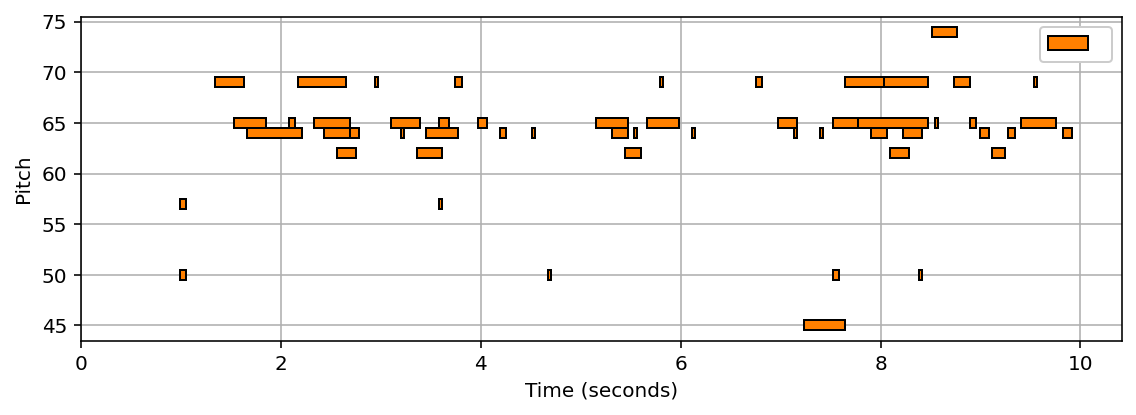

In [ ]:
import math
import torch.nn.functional as F
from mir_eval.util import midi_to_hz


def save_midi(path, pitches, intervals, velocities):
    """Saves extracted notes as a MIDI file.

    Args:
        path: the path to save the MIDI file
        pitches: np.ndarray of bin_indices
        intervals: list of tuple (onset_index, offset_index)
        velocities: list of velocity values
    """
    file = MidiFile()
    track = MidiTrack()
    file.tracks.append(track)
    ticks_per_second = file.ticks_per_beat * 2.0

    events = []
    for i in range(len(pitches)):
        events.append(
            dict(type='on',
                 pitch=pitches[i],
                 time=intervals[i][0],
                 velocity=velocities[i]))
        events.append(
            dict(type='off',
                 pitch=pitches[i],
                 time=intervals[i][1],
                 velocity=velocities[i]))
    events.sort(key=lambda row: row['time'])

    last_tick = 0
    for event in events:
        current_tick = int(event['time'] * ticks_per_second)
        velocity = int(event['velocity'] * 127)
        if velocity > 127:
            velocity = 127
        pitch = int(round(hz_to_midi(event['pitch'])))
        track.append(
            Message('note_' + event['type'],
                    note=pitch,
                    velocity=velocity,
                    time=current_tick - last_tick))
        last_tick = current_tick

    file.save(path)


# We use the example piano piece at the beginning.
audio_file = 'gct634-maestro/2009/MIDI-Unprocessed_08_R1_2009_01-04_ORIG_MID--AUDIO_08_R1_2009_08_R1_2009_03_WAV.flac'
audio, sr = soundfile.read(audio_file)
audio_seg = audio[:10*sr]

t_audio = torch.tensor(audio_seg).to(torch.float).to(runner.device)
pad_len = math.ceil(len(t_audio) / HOP_SIZE) * HOP_SIZE - len(t_audio)
t_audio = torch.unsqueeze(F.pad(t_audio, (0, pad_len)), 0)

frame_pred, onset_pred = model(t_audio)
p_est, i_est = extract_notes(onset_pred[0], frame_pred[0])

scaling = HOP_SIZE / SAMPLE_RATE
i_est = (i_est * scaling).reshape(-1, 2)
p_est = np.array([midi_to_hz(MIN_MIDI + pitch) for pitch in p_est])

midi_output_filename = 'output.midi'

save_midi(midi_output_filename, p_est, i_est, [64] * len(p_est))
midi_file = pretty_midi.PrettyMIDI(str(midi_output_filename))
synth_audio = midi_file.fluidsynth(fs=16000)


midi_score = libfmp.c1.midi_to_list(midi_output_filename)
libfmp.c1.visualize_piano_roll(midi_score, figsize=(8, 3))

ipd.Audio(synth_audio, rate=16000)


# Credit
This homework was implemented and improved by Taegyun Kwon and Juhan Nam from the KAIST Music and Audio Computing Lab.
